# Quick Start Tutorial: End-to-End Workflow

## Learning Objectives

In this tutorial you will learn how to:
1. Create a catalog
2. Define a data model for a catalog
3. Add features to a catalog
4. Solve a use case
5. Deploy and serve a feature list
6. Manage the feature list lifecycle

## Set up the prerequisites

Learning Objectives

In this section you will:
* import libraries
* start your local featurebyte server

### Load the featurebyte library and connect to the local instance of featurebyte

In [1]:
# library imports
import pandas as pd
import numpy as np
from datetime import datetime

# load the featurebyte SDK
import featurebyte as fb

print("FeatureByte version " + fb.version)

# start the local server, then wait for it to be healthy before proceeding
fb.playground()

2023-04-10 15:22:21.978 | INFO     | featurebyte.docker.manager:start_playground:330 | Starting featurebyte service | {}


FeatureByte version 0.1.7


featurebyte-worker Skipped - Image is already being pulled by featurebyte-server 
spark-thrift Pulling 
featurebyte-docs Pulling 
mongo-rs Pulling 
redis Pulling 
featurebyte-server Pulling 
redis Pulled 
spark-thrift Pulled 
mongo-rs Pulled 
featurebyte-server Pulled 
featurebyte-docs Pulled 
Container redis  Running
Container mongo-rs  Running
Container featurebyte-worker  Running
Container featurebyte-server  Running
Container mongo-rs  Waiting
Container mongo-rs  Waiting
Container redis  Waiting
Container mongo-rs  Healthy
Container redis  Healthy
Container mongo-rs  Healthy
2023-04-10 15:22:24.155 | INFO     | featurebyte.docker.manager:start_playground:332 | Starting local spark service | {}
featurebyte-server Skipped - Image is already being pulled by featurebyte-worker 
featurebyte-docs Pulling 
featurebyte-worker Pulling 
mongo-rs Pulling 
spark-thrift Pulling 
redis Pulling 
spark-thrift Pulled 
redis Pulled 
mongo-rs Pulled 
featurebyte-docs Pulled 
featurebyte-worker Pulled

## Create a catalog

Once you have a feature store, you can create a Catalog, which acts as a central repository for metadata related to FeatureByte objects: tables, entities, features, and feature lists.

For data sources covering multiple domains, use separate Catalogs for each domain to maintain clarity and easy access to domain-specific metadata.

Learning Objectives

In this section you will:
* learn about catalogs
* create a new catalog

### Concept: Catalog

A FeatureByte Catalog serves as a centralized repository for storing metadata about FeatureByte objects such as tables, entities, features, and feature lists associated with a specific domain. It functions as an effective tool for facilitating collaboration among team members working on similar use cases or utilizing the same data source within a data warehouse.

### Example: Create a new catalog

In [2]:
catalog_name = "quick start end-to-end " + datetime.now().strftime("%Y%m%d:%H%M")

# create a catalog
catalog = fb.Catalog.create(catalog_name)

In [3]:
# you can activate an existing catalog
catalog = fb.Catalog.activate(catalog_name)

## Define a Data Model

Defining your Catalog's Data Model is crucial for facilitating feature engineering, organization, and serving of features and feature lists. It is an infrequent but essential task to ensure good practices. 

Learning Objectives

In this section you will:
* be introduced to the case study dataset
* declare FeatureByte catalog tables
* define data cleaning operations
* declare and tag entities

### Case Study: French grocery dataset

The French grocery dataset contains four tables containing data from a chain of grocery stores.

The data source has already been declared in the playground feature store that was installed as part of FeatureByte.

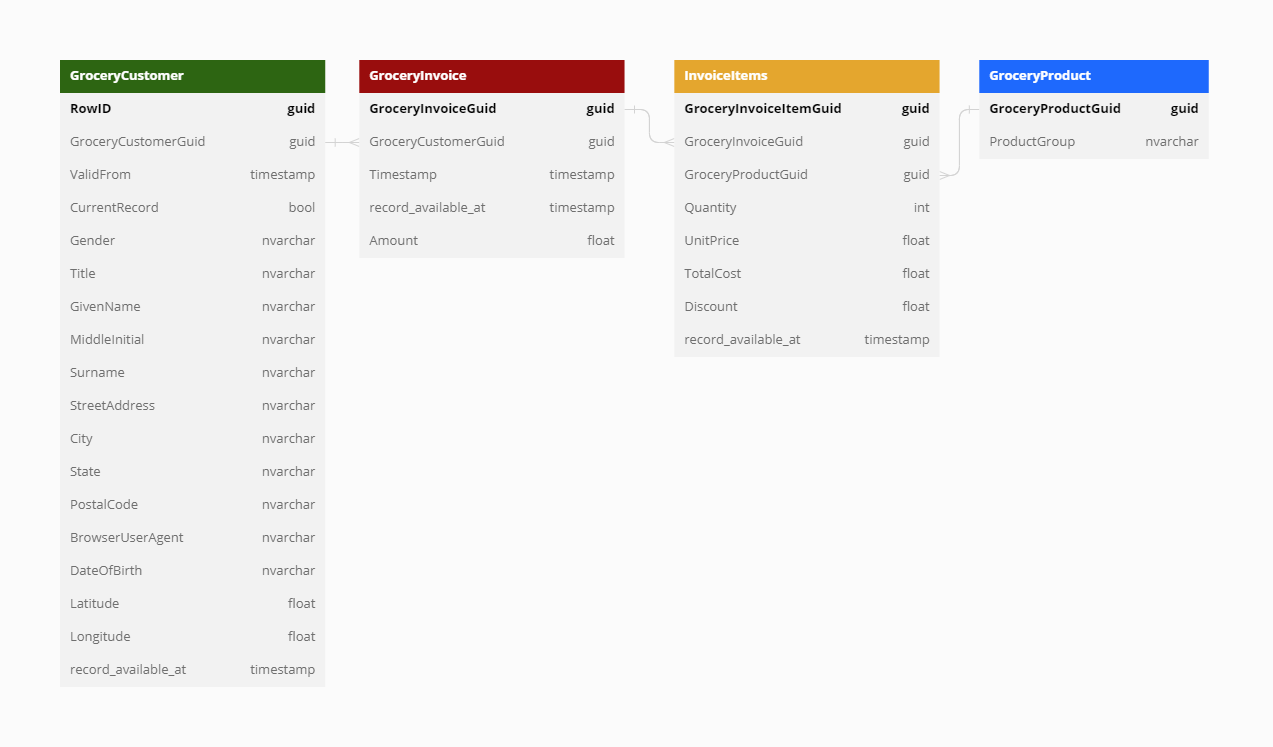

### Concept: Data source

A data source is a collection of tables accessible via a connection to a data warehouse or database. It is used to explore and retrieve details about tables that can be used as source table in the FeatureByte catalog. 

### Example: Connect to a pre-defined data source

In [4]:
# get data source from the local spark feature store
ds = fb.FeatureStore.get("playground").get_data_source()

### Concept: FeatureByte catalog table

A Catalog Table serves as a logical representation of a source table within the Catalog. The Catalog Table does not store data itself, but instead provides a way to access the source table and centralize essential metadata for feature engineering.

The metadata on the table’s type determines the types of feature engineering operations that are possible and enforce guardrails accordingly. 

### Example: Declare catalog tables

In [5]:
# register GroceryInvoice as an event data
invoice_table = ds.get_table(
            database_name="spark_catalog",
            schema_name="GROCERY",
            table_name="GROCERYINVOICE"
        ).create_event_table(   
            name="GROCERYINVOICE",
            event_id_column="GroceryInvoiceGuid",
            event_timestamp_column="Timestamp",
            record_creation_timestamp_column="record_available_at"
        )

# show sample data
invoice_table.sample(5)

,GroceryInvoiceGuid,GroceryCustomerGuid,Timestamp,record_available_at,Amount
0,09384ec7-f3a4-466e-bc8e-41023937354b,7005c3a2-a903-4c15-9ffb-d52b0d5eba14,2022-10-31 15:05:32,2022-10-31 16:01:00,2.89
1,381522c8-55b3-4015-9ce2-938ea8828683,82a104d2-ad63-4079-8ccc-767c5b88afcb,2022-11-17 15:24:37,2022-11-17 16:01:00,3.74
2,d687e93b-557e-49f6-a412-095c4448f305,a90ab8bf-1c87-4c98-811f-6b8cc8a7b7bd,2022-03-03 21:04:48,2022-03-03 22:01:00,48.18
3,530bd051-e009-42f0-b598-13e3947a4b46,ebd6f63f-9425-4175-8f69-457979d69741,2022-06-13 16:53:28,2022-06-13 17:01:00,25.97
4,2ec3b3b4-d7d1-4a69-82a6-53f91632b209,2ebe2af2-146a-4a94-b701-22146449a1a8,2023-01-09 09:28:05,2023-01-09 10:01:00,4.99


In [6]:
# register invoice items as an item table
items_table = ds.get_table(
            database_name="spark_catalog",
            schema_name="GROCERY",
            table_name="INVOICEITEMS"
        ).create_item_table(
            name="INVOICEITEMS",
            event_id_column="GroceryInvoiceGuid",
            item_id_column="GroceryInvoiceItemGuid",
            event_table_name="GROCERYINVOICE"
        )

# show sample data
items_table.sample(5)

,GroceryInvoiceItemGuid,GroceryInvoiceGuid,GroceryProductGuid,Quantity,UnitPrice,TotalCost,Discount,record_available_at
0,e7e96e3c-ef4e-4644-903a-ca378a5860b8,a90aa7d8-a41b-4841-adcf-59178e0f0eea,2f5694f4-d6ca-4bfa-adbc-6a3750406306,1.0,0.88,0.88,0.41,2022-07-26 22:01:00
1,b1ea1f28-2b18-4643-bce6-cf2f3c336741,dc9d5f0d-e6d3-4a44-8528-a554f7a54fcb,6733d7ec-7dcd-4c18-a787-5c7957a42ad0,1.0,0.00,0.00,0.00,2023-03-28 15:01:00
2,d62dccc6-748d-4396-83e0-f3755849061e,ac1123e2-7052-4669-a956-e3057fb1f064,663e9a7b-7e86-48fe-9033-d52607caa602,1.0,3.49,3.49,0.00,2022-06-23 19:01:00
3,70f7bf5a-e6f6-471b-9ebf-5a060e0f6791,b3e69b48-83e7-42c2-a3ce-2158d73ec21c,d139e012-49a1-4fd6-b2f5-bb32556d1d36,1.0,1.00,1.00,0.00,2022-02-23 15:01:00
4,988de65a-be63-4018-b4fe-8b5b649795f0,7c476831-468f-44c0-b3f0-2e8a87df8b65,fb815fd5-9199-4984-a24d-edb489708a03,1.0,0.79,0.79,0.30,2022-03-17 17:01:00


### Concept: Feature job setting

The Feature Job Setting in FeatureByte captures essential details about batch feature computations for the online feature store, including the frequency and timing of the batch process, as well as the assumed blind spot for the data. This helps to maintain consistency between offline and online feature values and ensures accurate historical serving that reflects the production environment. The setting comprises three parameters:

* The frequency parameter specifies how often the batch process should run.
* The time_modulo_frequency parameter defines the timing of the batch process.
* The blind_spot parameter sets the time gap between feature computation and the latest event timestamp to be processed.

To ensure consistency of Feature Job Setting across features created by different team members, a Default Feature Job Setting is defined at the table level. However, it's possible to override this setting during feature declaration.

### Example: Feature job settings analysis

In [7]:
# initialize the feature job settings for the invoice table
invoice_table.initialize_default_feature_job_setting()

Done! |████████████████████████████████████████| 100% in 6.1s (16.40%/s)                                                


### Concept: Cleaning operations

Cleaning operations determine the process for cleaning data in a table column before performing feature engineering. The cleaning operations can either be set as a default operation in the metadata of a table column or established when creating a view.

These operations specify how to manage the following scenarios:
* Missing values
* Disguised values
* Values that are not in an anticipated list
* Numeric values and dates that are out of boundaries

It is important to note that cleaning operations for a specific table column may consist of a sequence of operations, which are executed in a particular order. Imputed values from previous operations should not be identified as values to be cleaned in subsequent operations.

### Example: Correct negative discounts and missing discount amounts

In [8]:
# discount amount cannot be negative
items_table.Discount.update_critical_data_info(
    cleaning_operations=[
        fb.MissingValueImputation(imputed_value=0),
        fb.ValueBeyondEndpointImputation(type="less_than", end_point=0, imputed_value=0),
    ]
)

### Concept: Entity

An entity is a real-world object or concept that is represented by fields in source tables. Entities facilitate automatic table join definitions, serve as the unit of analysis for feature engineering, and aid in organizing features, feature lists, and use cases. Examples of entities can include customers, merchants, cities, products, and orders.

Before features can be assigned to an entity, the user must identify the relevant columns in the Catalog Tables that define or refer to the entity. This is done through “tagging” columns with their semantic information.

### Example: Declare new entities

In [9]:
# register new entities
entity1 = catalog.create_entity(name="grocerycustomer", serving_names=["GROCERYCUSTOMERGUID"])
entity2 = catalog.create_entity(name="groceryinvoice", serving_names=["GROCERYINVOICEGUID"])

### Concept: Entity Tagging

The process of entity tagging involves identifying the specific columns in tables that  identify or reference a particular entity. These columns are often primary keys, natural keys, or foreign keys that are unique to each entity. This process is a critical step in preparing data before feature engineering, as it enables users to assign features to individual entities or join related data across multiple tables.

### Example: Entity tagging

In [10]:
# tag the entities for the grocery invoice table
invoice_table.GroceryInvoiceGuid.as_entity("groceryinvoice")
invoice_table.GroceryCustomerGuid.as_entity("grocerycustomer")

# tag the entities for the grocery items table
items_table.GroceryInvoiceGuid.as_entity("groceryinvoice")

## Add Features to a Catalog

Learning Objectives

In this section you will:
* learn the purpose of views
* create views from tables
* transform data in a view
* filter rows in a view

### Concept: FeatureByte Views

Views are cleaned versions of Catalog tables and offer a flexible and efficient way to work with Catalog tables. They allow operations like creating new columns, filtering records, conditionally editing columns, extracting lags, capturing attribute changes, and joining views, similar to Pandas. Unlike Pandas DataFrames, which require loading all data into memory, views are materialized only when needed during previews or feature materialization.

When a view is created, it inherits the metadata of the Catalog Table it originated from. There are currently five types of views supported: Event Views, Item Views, Dimension Views, Slowly Changing Dimension (SCD) Views, and Change Views.

The syntax used to manipulate data in a FeatureByte view is similar to a Pandas DataFrame, making it easier to learn.

By default, data accessed through views is cleaned according to the default cleaning operations specified in the Catalog Tables. However, it is still possible to perform data manipulation based on the raw data present in the source table using the raw view attribute or to overwrite the cleaning operations when the view is created.

View operations are only materialized for purposes such as samples, exploratory data analysis, or feature materialization. FeatureByte follows a lazy execution strategy where view operations are translated into a graphical representation of intended operations.

### Example: Create views from tables

In [11]:
# get the view objects
items_view = items_table.get_view()
invoice_view = invoice_table.get_view()

### Concept: Feature

To train and predict using Machine Learning models, input data is required, which is commonly referred to as features.

### Concept: Observation set

An observation set is a table of entity keys and points in time, for which you wish to materialize feature values. The entities keys define which entities a feature will materialize, and the points in time define at which timestamps.

### Example: Creating an observation set

In [12]:
# get some invoice IDs and invoice event timestamps from 2022
filter = (invoice_view["Timestamp"].dt.year == 2022) & (invoice_view["Timestamp"].dt.month >= 10)
observation_set = (
    invoice_view[filter].sample(5)[["GroceryCustomerGuid", "Timestamp"]]
    .rename({
        "Timestamp": "POINT_IN_TIME",
        "GroceryCustomerGuid": "GROCERYCUSTOMERGUID",
    }, axis=1)
)
display(observation_set)

,GROCERYCUSTOMERGUID,POINT_IN_TIME
0,30e3fbe4-3cbe-4d51-b6ca-1f990ef9773d,2022-12-17 12:12:40
1,7484ebd5-ee65-49f8-abce-8becd7af39fb,2022-12-26 18:12:37
2,a906b457-33c7-4186-a4a8-77f2ad018c2b,2022-12-04 16:13:10
3,e0453f48-5d57-4681-84b3-0f07b15ab48e,2022-11-05 17:08:56
4,e459196f-bf0a-41a1-a307-a4cfcf41fea9,2022-11-27 17:42:11


### Concept: Aggregate feature

Aggregate features are an important type of feature engineering that involves applying various aggregation functions to a collection of data points grouped by an entity (or a tuple of entities). Common aggregation functions include the latest, count, sum, average, minimum, maximum, and standard deviation and it's important to consider the temporal aspect when conducting these aggregation operations.

There are three main types of aggregate features, which are simple aggregates, aggregates over a window and aggregates "as at" a point-in-time.

If a feature is intended to capture patterns of interaction between two or more entities, these aggregations are grouped by the tuple of the entities. For instance, an aggregate feature can be created to show the amount spent by a customer with a merchant in the recent past.

### Concept: Aggregates over a window

Aggregates over a window refer to features that are generated by aggregating data within a specific time frame. These types of features are commonly used for analyzing event and item data.

### Example: Syntax for creating an aggregate feature over a window

In [13]:
# get the discount on a grocery item for each customer over 90 days and 180 days, grouped by customer
customer_max_discount = items_view.groupby("GroceryCustomerGuid").aggregate_over(
    "Discount",
    method=fb.AggFunc.MAX,
    feature_names=["CustomerMaxDiscount_30days", "CustomerMaxDiscount_90days"],   
    fill_value=0,
    windows=['30d', '90d']
)
customer_max_discount.save()

# create a multi-row preview of the feature values
display(customer_max_discount.preview(observation_set))

,GROCERYCUSTOMERGUID,POINT_IN_TIME,CustomerMaxDiscount_30days,CustomerMaxDiscount_90days
0,30e3fbe4-3cbe-4d51-b6ca-1f990ef9773d,2022-12-17 12:12:40,2.36,4.50
1,7484ebd5-ee65-49f8-abce-8becd7af39fb,2022-12-26 18:12:37,2.02,2.58
2,a906b457-33c7-4186-a4a8-77f2ad018c2b,2022-12-04 16:13:10,2.73,2.73
3,e0453f48-5d57-4681-84b3-0f07b15ab48e,2022-11-05 17:08:56,0.60,1.57
4,e459196f-bf0a-41a1-a307-a4cfcf41fea9,2022-11-27 17:42:11,1.65,1.65


In [14]:
# get the total amount of invoices for each customer over the past 14 days
customer_invoice_total_14d = items_view.groupby("GroceryCustomerGuid").aggregate_over(
    "Discount",
    method=fb.AggFunc.SUM,
    feature_names=["CustomerInvoiceTotal_14days"],
    fill_value=0,
    windows=['14d']
)
customer_invoice_total_14d.save()

## Solve a Use Case

Learning Objectives

In this section you will learn how to:
* design an observation set for training data
* create a feature list
* create historical training data
* consume training data to train a machine learning model

### Case Study: Predicting Customer Spend

Your chain of grocery stores wants to target market customers immediately after each purchase. As one step in this marketing campaign, they want to predict future customer spend in the 14 days after a purchase.

### Example: Create an observation set for training data

In [15]:
# filter to get the second half of 2022
filter = (invoice_view["Timestamp"].dt.year == 2022) & (invoice_view["Timestamp"].dt.month >= 2)

# create a pandas data frame a sample of the customer IDs and timestamps
observation_set_features = observation_set = (
    invoice_view[filter].sample(1000)[["GroceryCustomerGuid", "Timestamp"]]
    .rename({
        "Timestamp": "POINT_IN_TIME",
        "GroceryCustomerGuid": "GROCERYCUSTOMERGUID",
    }, axis=1)
)
display(observation_set_features)

,GROCERYCUSTOMERGUID,POINT_IN_TIME
0,03732ad7-f757-40dd-a834-9a6654544009,2022-07-15 18:19:20
1,ec0a3d0b-1196-439a-8682-2ad3704db074,2022-09-18 18:55:38
2,091be817-ce2c-4a3b-96e0-526b9b2a33f6,2022-06-30 16:30:35
3,6c6e4d82-0856-4709-8e80-695fe85afebf,2022-08-07 18:43:24
4,ecb0a59a-124e-4ac2-8181-5f6f64b4b5cf,2022-02-15 17:00:36
...,...,...
995,a7ada4a3-fd92-44e6-a232-175c90b1c939,2022-11-20 12:35:31
996,b5423dbc-db1c-4dbf-8721-b9fba6bcdd9b,2022-09-29 13:40:19
997,42d75f67-602c-4fa2-becf-bbc8c1ea5bb2,2022-06-20 20:33:26
998,84e20f8f-27d8-4e90-b6a0-d08122144ab8,2022-06-28 13:53:03


### Concept: Feature list

A Feature List is a set of features that is typically crafted to address a specific Use Case.

### Example: Create a feature list

In [16]:
# create a feature list
feature_list = fb.FeatureList([
    customer_max_discount,
    customer_invoice_total_14d
], name = "customer features")
feature_list.save()

Saving Feature(s) |████████████████████████████████████████| 3/3 [100%] in 0.0s (99.06/s)                               
Loading Feature(s) |████████████████████████████████████████| 3/3 [100%] in 1.3s (2.27/s)                               


In [17]:
# create a feature list for the target
target_list = fb.FeatureList([
    customer_invoice_total_14d
], name = "Target feature")
target_list.save()

Saving Feature(s) |████████████████████████████████████████| 1/1 [100%] in 0.0s (27.93/s)                               
Loading Feature(s) |████████████████████████████████████████| 1/1 [100%] in 0.3s (3.15/s)                               


### Concept: Materialization

A feature definition is a set of instructions for computing the feature on past or newly available data. The act of computing features is known as Feature Materialization.

### Example: Get historical values

In [18]:
# use the get historical features function to get the feature values for the observation set
training_data_features = feature_list.get_historical_features(observation_set_features)
display(training_data_features)

Retrieving Historical Feature(s) |████████████████████████████████████████| 1/1 [100%] in 8.5s (0.12/s)                 


,GROCERYCUSTOMERGUID,POINT_IN_TIME,CustomerInvoiceTotal_14days,CustomerMaxDiscount_90days,CustomerMaxDiscount_30days
0,03732ad7-f757-40dd-a834-9a6654544009,2022-07-15 18:19:20,8.78,3.11,2.19
1,ec0a3d0b-1196-439a-8682-2ad3704db074,2022-09-18 18:55:38,4.30,9.96,9.96
2,091be817-ce2c-4a3b-96e0-526b9b2a33f6,2022-06-30 16:30:35,14.72,11.56,4.04
3,6c6e4d82-0856-4709-8e80-695fe85afebf,2022-08-07 18:43:24,2.62,3.25,3.25
4,ecb0a59a-124e-4ac2-8181-5f6f64b4b5cf,2022-02-15 17:00:36,35.81,6.27,6.27
...,...,...,...,...,...
995,a7ada4a3-fd92-44e6-a232-175c90b1c939,2022-11-20 12:35:31,31.02,4.69,3.24
996,b5423dbc-db1c-4dbf-8721-b9fba6bcdd9b,2022-09-29 13:40:19,15.96,13.45,13.45
997,42d75f67-602c-4fa2-becf-bbc8c1ea5bb2,2022-06-20 20:33:26,29.03,2.49,2.00
998,84e20f8f-27d8-4e90-b6a0-d08122144ab8,2022-06-28 13:53:03,12.23,3.00,3.00


### Example: Get target values

When target values use aggregates or time offsets, you first need to offset the point in time by the time window.

In [19]:
# add 14 days to the timestamps in the observation set
observation_set_target = observation_set_features.copy()
observation_set_target["POINT_IN_TIME"] = observation_set_target["POINT_IN_TIME"] + pd.DateOffset(days=14)
display(observation_set_target)

,GROCERYCUSTOMERGUID,POINT_IN_TIME
0,03732ad7-f757-40dd-a834-9a6654544009,2022-07-29 18:19:20
1,ec0a3d0b-1196-439a-8682-2ad3704db074,2022-10-02 18:55:38
2,091be817-ce2c-4a3b-96e0-526b9b2a33f6,2022-07-14 16:30:35
3,6c6e4d82-0856-4709-8e80-695fe85afebf,2022-08-21 18:43:24
4,ecb0a59a-124e-4ac2-8181-5f6f64b4b5cf,2022-03-01 17:00:36
...,...,...
995,a7ada4a3-fd92-44e6-a232-175c90b1c939,2022-12-04 12:35:31
996,b5423dbc-db1c-4dbf-8721-b9fba6bcdd9b,2022-10-13 13:40:19
997,42d75f67-602c-4fa2-becf-bbc8c1ea5bb2,2022-07-04 20:33:26
998,84e20f8f-27d8-4e90-b6a0-d08122144ab8,2022-07-12 13:53:03


In [20]:
# Materialize the target feature using get historical features
training_data_target = target_list.get_historical_features(observation_set_target)

# remove the offset from the point in time column
training_data_target["POINT_IN_TIME"] = training_data_target["POINT_IN_TIME"] - pd.DateOffset(days=14)

# rename the CustomerInvoiceTotal_14days column to Target
training_data_target = training_data_target.rename({"CustomerInvoiceTotal_14days": "Target"}, axis=1)

display(training_data_target)

Retrieving Historical Feature(s) |████████████████████████████████████████| 1/1 [100%] in 6.8s (0.15/s)                 


,GROCERYCUSTOMERGUID,POINT_IN_TIME,Target
0,03732ad7-f757-40dd-a834-9a6654544009,2022-07-15 18:19:20,12.20
1,ec0a3d0b-1196-439a-8682-2ad3704db074,2022-09-18 18:55:38,15.05
2,091be817-ce2c-4a3b-96e0-526b9b2a33f6,2022-06-30 16:30:35,27.38
3,6c6e4d82-0856-4709-8e80-695fe85afebf,2022-08-07 18:43:24,2.27
4,ecb0a59a-124e-4ac2-8181-5f6f64b4b5cf,2022-02-15 17:00:36,33.65
...,...,...,...
995,a7ada4a3-fd92-44e6-a232-175c90b1c939,2022-11-20 12:35:31,29.36
996,b5423dbc-db1c-4dbf-8721-b9fba6bcdd9b,2022-09-29 13:40:19,14.22
997,42d75f67-602c-4fa2-becf-bbc8c1ea5bb2,2022-06-20 20:33:26,31.89
998,84e20f8f-27d8-4e90-b6a0-d08122144ab8,2022-06-28 13:53:03,18.61


### Example: Merging materialized values for features and target

In [21]:
# merge training data features and training data target
training_data = training_data_features.merge(training_data_target, on=["GROCERYCUSTOMERGUID", "POINT_IN_TIME"])
display(training_data)

,GROCERYCUSTOMERGUID,POINT_IN_TIME,CustomerInvoiceTotal_14days,CustomerMaxDiscount_90days,CustomerMaxDiscount_30days,Target
0,03732ad7-f757-40dd-a834-9a6654544009,2022-07-15 18:19:20,8.78,3.11,2.19,12.20
1,ec0a3d0b-1196-439a-8682-2ad3704db074,2022-09-18 18:55:38,4.30,9.96,9.96,15.05
2,091be817-ce2c-4a3b-96e0-526b9b2a33f6,2022-06-30 16:30:35,14.72,11.56,4.04,27.38
3,6c6e4d82-0856-4709-8e80-695fe85afebf,2022-08-07 18:43:24,2.62,3.25,3.25,2.27
4,ecb0a59a-124e-4ac2-8181-5f6f64b4b5cf,2022-02-15 17:00:36,35.81,6.27,6.27,33.65
...,...,...,...,...,...,...
995,a7ada4a3-fd92-44e6-a232-175c90b1c939,2022-11-20 12:35:31,31.02,4.69,3.24,29.36
996,b5423dbc-db1c-4dbf-8721-b9fba6bcdd9b,2022-09-29 13:40:19,15.96,13.45,13.45,14.22
997,42d75f67-602c-4fa2-becf-bbc8c1ea5bb2,2022-06-20 20:33:26,29.03,2.49,2.00,31.89
998,84e20f8f-27d8-4e90-b6a0-d08122144ab8,2022-06-28 13:53:03,12.23,3.00,3.00,18.61


### Example: Training a scikit learn model

Note that you will need to install scikit learn https://scikit-learn.org/stable/install.html

In [22]:
import sklearn
# use sklearn to train a random forest regression model on the training data
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(training_data.drop(
    columns=["GROCERYCUSTOMERGUID", "POINT_IN_TIME"]), training_data["Target"], test_size=0.2, random_state=42)

# train the model
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

# get predictions
y_pred = model.predict(X_test)

# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: ", mse)

# save the model
import joblib
joblib.dump(model, "model.pkl")

Mean squared error:  3.5210243412247086


['model.pkl']

## Deploy and Serve a Feature List

Deploying a feature list is easy. FeatureByte automatically materializes features in the online feature store without requiring separate pipelines or tools. Simply run the deploy method of your feature list in the SDK.

Once a feature list is deployed, the online feature store offers pre-computed feature values.

Learning Objectives

In this tutorial you will learn how to:
1. manage the readiness of a feature
2. deploy a feature list
3. consume a feature list via API

### Concept: Feature readiness

A feature's readiness indicate a feature's suitability for use in feature lists.

DEPRECATED: Indicates that the feature version is not recommended for either training or online serving.<br>
QUARANTINE: Indicates that the feature version has recently had some issues and should be used with caution. It is currently under review.<br>
DRAFT: The feature is being prototyped and is not yet ready for production.<br>
PRODUCTION_READY: Indicates that the feature version is ready to be used in production.<br>

### Example: Set features to production ready

In [23]:
# change the state features to be production ready
for feature_name in feature_list.list_features().name:
    feature = catalog.get_feature(feature_name)
    feature.update_readiness("PRODUCTION_READY")

# display the features
feature_list.list_features()

,name,version,dtype,readiness,online_enabled,tables,primary_tables,entities,primary_entities,created_at
0,CustomerInvoiceTotal_14days,V230410,FLOAT,PRODUCTION_READY,False,"[GROCERYINVOICE, INVOICEITEMS]",[INVOICEITEMS],[grocerycustomer],[grocerycustomer],2023-04-10 19:22:42.321
1,CustomerMaxDiscount_90days,V230410,FLOAT,PRODUCTION_READY,False,"[GROCERYINVOICE, INVOICEITEMS]",[INVOICEITEMS],[grocerycustomer],[grocerycustomer],2023-04-10 19:22:40.308
2,CustomerMaxDiscount_30days,V230410,FLOAT,PRODUCTION_READY,False,"[GROCERYINVOICE, INVOICEITEMS]",[INVOICEITEMS],[grocerycustomer],[grocerycustomer],2023-04-10 19:22:39.643


### Example: Deploy a feature list

In [24]:
# deploy the state feature list
feature_list.deploy(enable=True)

# set the feature status to published
feature_list.update_status("PUBLISHED")

# display the feature lists
catalog.list_feature_lists()

Loading Feature(s) |████████████████████████████████████████| 3/3 [100%] in 0.6s (5.17/s)                               
Done! |████████████████████████████████████████| 100% in 33.4s (2.99%/s)                                                


,name,num_features,status,deployed,readiness_frac,online_frac,tables,entities,created_at
0,Target feature,1,DRAFT,False,1.0,1.0,"[GROCERYINVOICE, INVOICEITEMS]",[grocerycustomer],2023-04-10 19:22:45.290
1,customer features,3,PUBLISHED,True,1.0,1.0,"[GROCERYINVOICE, INVOICEITEMS]",[grocerycustomer],2023-04-10 19:22:43.521


### Point in time for deployment

The production feature serving API uses the current time as its point in time. To consume the feature list, send only the primary entity via the serving name.

### Automatically create a Python function for consuming the API

You can either use a python template or a shell script where the generated code will use the curl command to send the request.

For the python template, set the language parameter value as 'python'.
For the shell script, set the language parameter value as 'sh'.

In [25]:
# get a python template for consuming the feature serving API
feature_list.get_online_serving_code(language="python")

'from typing import Any, Dict\n\nimport pandas as pd\nimport requests\n\n\ndef request_features(entity_serving_names: Dict[str, Any]) -> pd.DataFrame:\n    """\n    Send POST request to online serving endpoint\n\n    Parameters\n    ----------\n    entity_serving_names: Dict[str, Any]\n        Entity serving name values to used for serving request\n\n    Returns\n    -------\n    pd.DataFrame\n    """\n    response = requests.post(\n        url="http://127.0.0.1:8088/feature_list/64346203425695270f724a7d/online_features",\n        params={"catalog_id": "643461f3425695270f724a6b"},\n        headers={"Content-Type": "application/json"},\n        json={"entity_serving_names": entity_serving_names},\n    )\n    assert response.status_code == 200, response.json()\n    return pd.DataFrame.from_dict(response.json()["features"])\n\n\nrequest_features([{"GROCERYCUSTOMERGUID": "a7ada4a3-fd92-44e6-a232-175c90b1c939"}])'

Copy the online serving code that was generated above, paste it into the cell below, then run it

In [26]:
# replace the contents of this Python code cell with the output from to_be_deployed.get_online_serving_code(language="python")

## Manage the feature list lifecycle

Learning objectives

In this section you will learn how to:
* make a new feature version
* change the feature job settings for a feature
* disable a deployment

### Example: Change the feature job settings for a feature

Note that changing feature job settings will only affect time-aware features e.g. features created using aggregate_over. It will not affect features based upon simple aggregation.

In [27]:
# show the feature job settings for the grocery invoice table
invoice_table.default_feature_job_setting

FeatureJobSetting(blind_spot='120s', frequency='3600s', time_modulo_frequency='65s')

In [28]:
# get the feature
customer_invoice_total_14d = catalog.get_feature("CustomerInvoiceTotal_14days")

# update the feature job settings for the customer_invoice_total_14d feature
customer_invoice_total_14d = customer_invoice_total_14d.create_new_version([
    fb.TableFeatureJobSetting(
      table_name="GROCERYINVOICE",
      feature_job_setting=fb.FeatureJobSetting(
        blind_spot="160s",
        frequency="60m",
        time_modulo_frequency="90s",
      )
    ),
  ]
)

# list the feature versions
feature_versions = customer_invoice_total_14d.list_versions()

### Example: Disable a deployment

In [29]:
# disable the feature list deployment
feature_list.deploy(enable=False)

Loading Feature(s) |████████████████████████████████████████| 3/3 [100%] in 1.1s (2.67/s)                               
Done! |████████████████████████████████████████| 100% in 9.3s (10.80%/s)                                                


## Next Steps

Now that you've completed the quick-start end-to-end tutorial, you can put your knowledge into practice or learn more:<br>
1. Learn more about feature engineering via the "Quick Start Feature Engineering" tutorial
2. Learn more about reusing features via the "Quick Start Reusing Features" tutorial
3. Learn about data modeling via the "Deep Dive Data Modeling" tutorial